Depot opening hours: 0h00-20h36
Total_cost: 1703
Number of routes: 15

Route 1: [0, 20, 21, 22, 23, 26, 28, 27, 24, 0]
Truck capacity: 110.0
Total distance travelled (cost): 43
Starting time: 0h00
Ending time: 20h08
Total time: 20h08



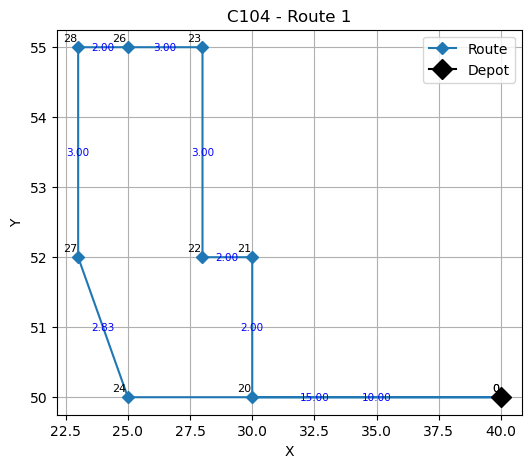

Route 2: [0, 67, 65, 63, 62, 66, 69, 68, 64, 0]
Truck capacity: 130.0
Total distance travelled (cost): 55
Starting time: 0h00
Ending time: 20h16
Total time: 20h16



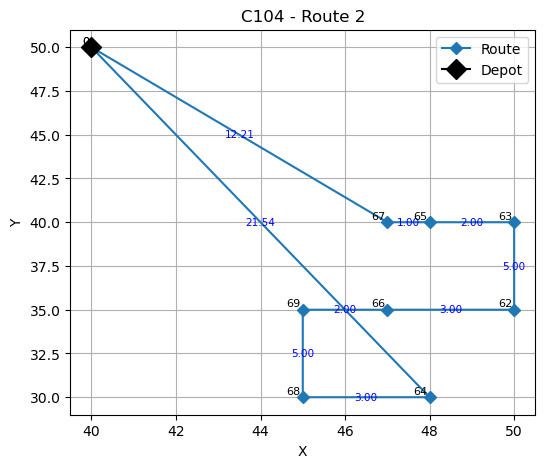

Route 3: [0, 5, 3, 4, 6, 7, 10, 75, 0]
Truck capacity: 100.0
Total distance travelled (cost): 55
Starting time: 0h00
Ending time: 20h13
Total time: 20h13



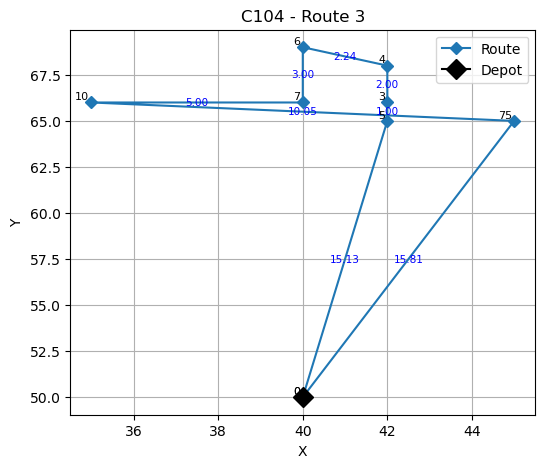

Route 4: [0, 25, 29, 30, 34, 36, 39, 37, 35, 31, 32, 0]
Truck capacity: 190.0
Total distance travelled (cost): 102
Starting time: 2h34
Ending time: 21h50
Total time: 19h16



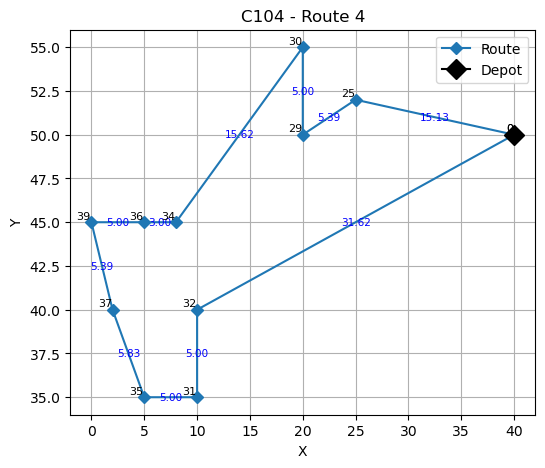

Route 5: [0, 43, 42, 41, 40, 44, 45, 46, 48, 50, 51, 52, 49, 0]
Truck capacity: 150.0
Total distance travelled (cost): 66
Starting time: 0h00
Ending time: 19h06
Total time: 19h06



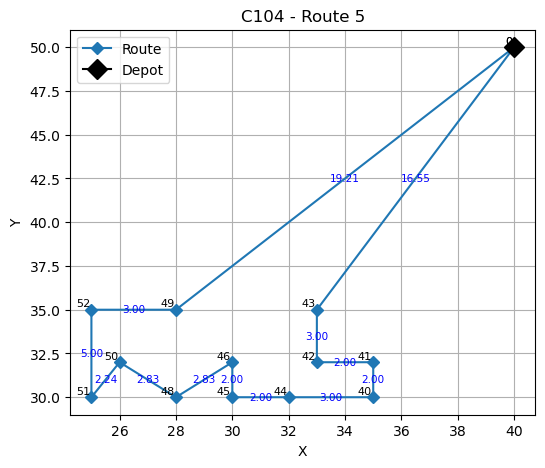

Route 6: [0, 47, 61, 72, 74, 90, 89, 88, 85, 86, 83, 82, 0]
Truck capacity: 200.0
Total distance travelled (cost): 128
Starting time: 0h00
Ending time: 19h14
Total time: 19h14



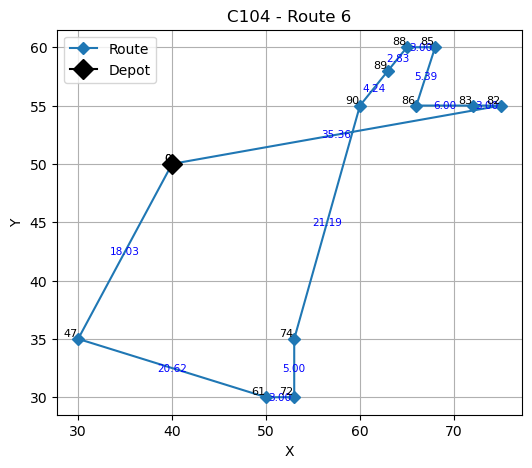

Route 7: [0, 8, 9, 2, 1, 98, 96, 95, 0]
Truck capacity: 130.0
Total distance travelled (cost): 89
Starting time: 3h57
Ending time: 22h59
Total time: 19h02



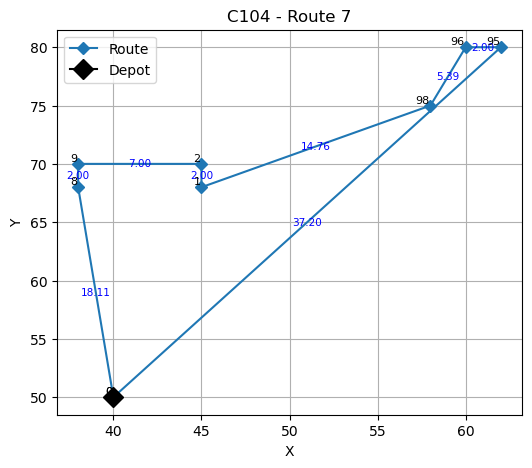

Route 8: [0, 11, 17, 18, 19, 16, 14, 12, 0]
Truck capacity: 130.0
Total distance travelled (cost): 96
Starting time: 7h08
Ending time: 26h23
Total time: 19h14



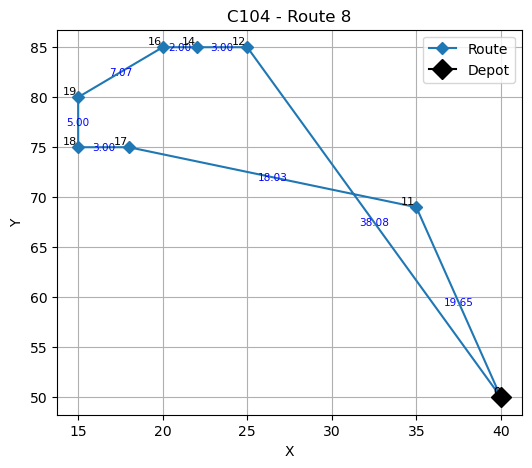

Route 9: [0, 91, 87, 84, 94, 93, 97, 81, 78, 0]
Truck capacity: 180.0
Total distance travelled (cost): 177
Starting time: 0h00
Ending time: 19h00
Total time: 19h00



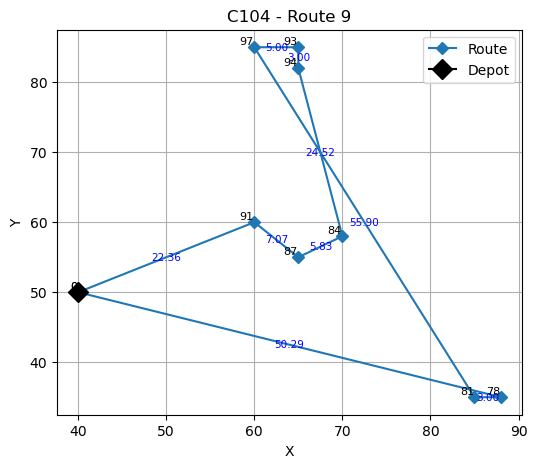

Route 10: [0, 13, 15, 99, 71, 70, 73, 0]
Truck capacity: 140.0
Total distance travelled (cost): 196
Starting time: 0h00
Ending time: 20h27
Total time: 20h27



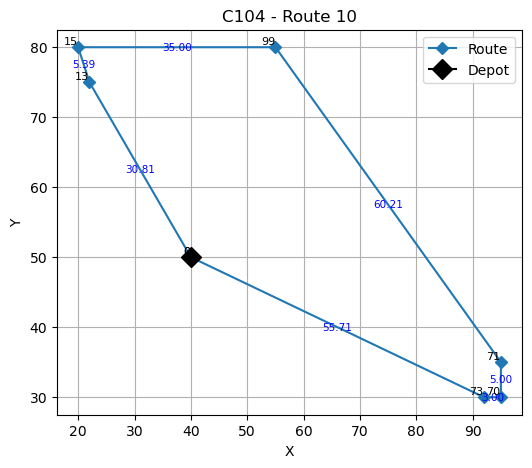

Route 11: [0, 33, 38, 59, 57, 54, 56, 80, 0]
Truck capacity: 200.0
Total distance travelled (cost): 201
Starting time: 0h00
Ending time: 19h38
Total time: 19h38



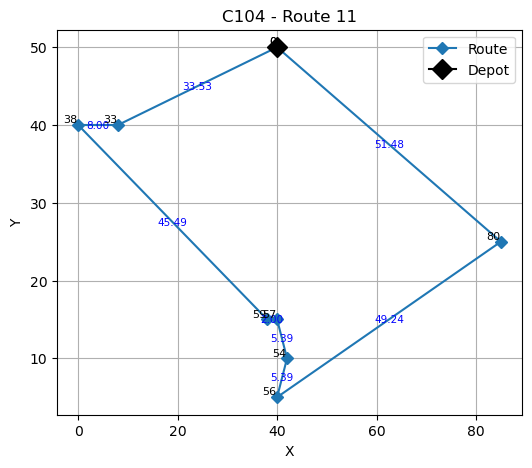

Route 12: [0, 55, 53, 58, 60, 79, 0]
Truck capacity: 90.0
Total distance travelled (cost): 164
Starting time: 1h00
Ending time: 15h13
Total time: 14h13



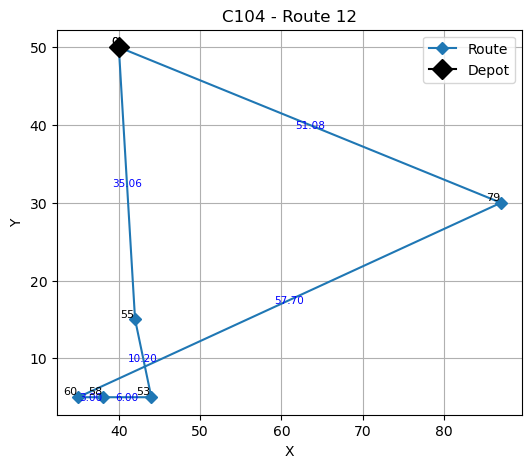

Route 13: [0, 100, 0]
Truck capacity: 20.0
Total distance travelled (cost): 77
Starting time: 10h09
Ending time: 23h04
Total time: 12h55



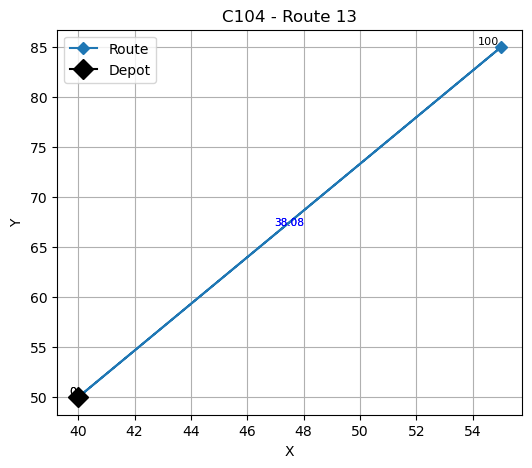

Route 14: [0, 92, 77, 0]
Truck capacity: 30.0
Total distance travelled (cost): 156
Starting time: 5h24
Ending time: 17h20
Total time: 11h56



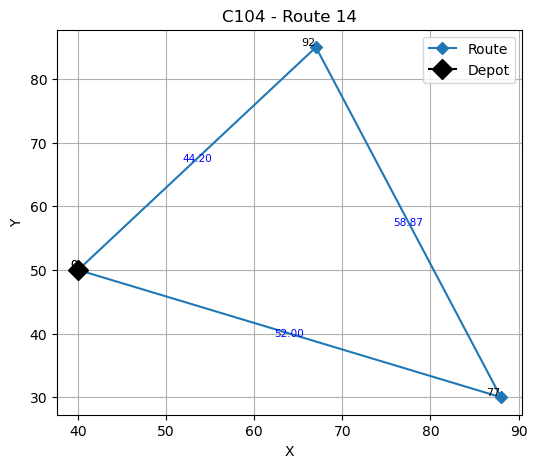

Route 15: [0, 76, 0]
Truck capacity: 10.0
Total distance travelled (cost): 105
Starting time: 2h31
Ending time: 8h16
Total time: 5h45



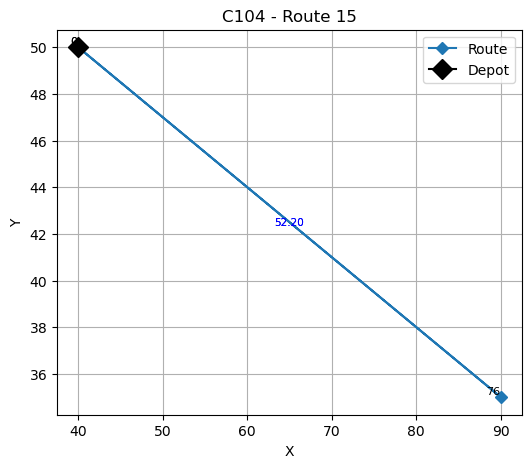

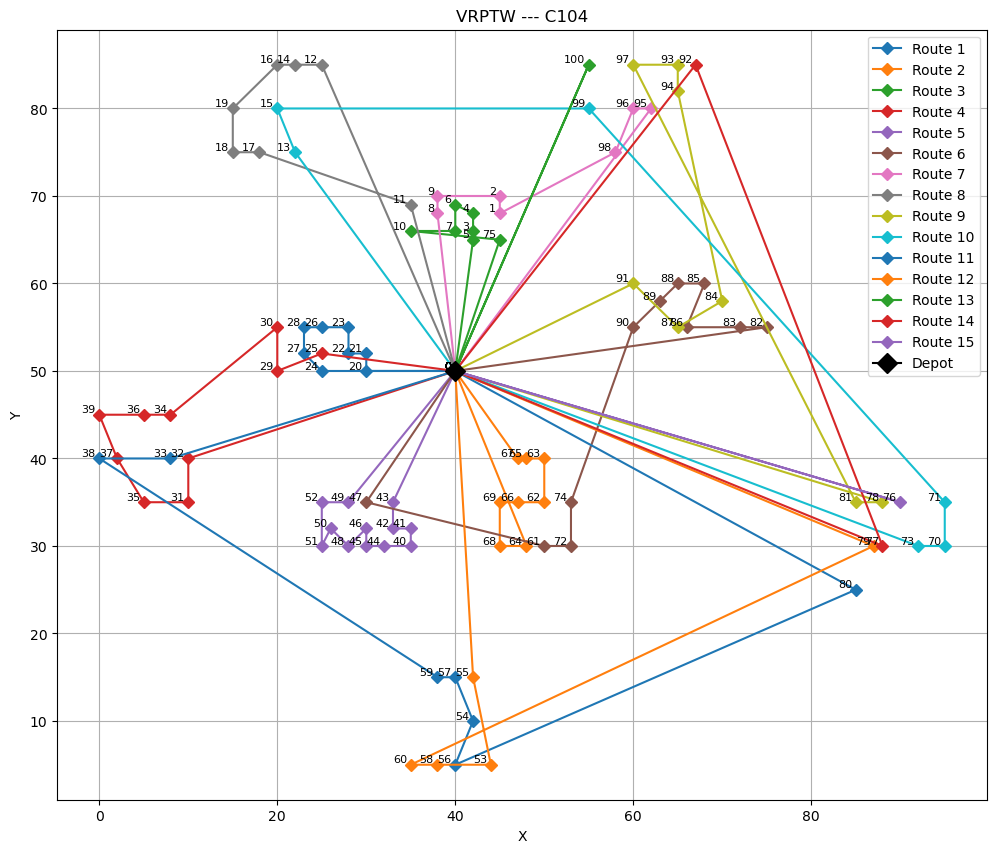

In [154]:
# used ressource :
# https://medium.com/@writingforara/solving-vehicle-routing-problems-with-python-heuristics-algorithm-2cc57fe7079c

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

def read_excel_file(file_path, sheet_name):
    """
    Read coordinates and demand values from a specific sheet in an Excel file.
    Assumes the data is in columns labeled 'X', 'Y', and 'Demand'.
    """
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    coordinates = df[['X', 'Y']].values
    demands = df['Demand'].values
    return coordinates, demands

def read_txt_file(file_path):
    """
    Reads a VRP text file and extracts vehicle and customer informations.
    """
    with open(file_path, 'r') as file:      # Read data
        lines = file.readlines()            # Split data into line
    vehicle_info = lines[4].split()         # Informations about vehicles are on line 5 for Solomon instance (index 4)
    vehicle_number = vehicle_info[0]        # Number of vehicle available
    vehicle_capacity = vehicle_info[1]      # Maximun capacity allowed in vehicle
    customer_data_start = lines.index("CUSTOMER\n") + 3  # Informations about customers start 3 lines after the index of the word "CUSTOMER"
    customer_lines = lines[customer_data_start:]
    
    coordinates = []
    demands = []
    ready_times = []
    due_times = []
    service_times = []
    
    for line in customer_lines:
        if line.strip():  # Skip empty lines
            values = list(map(float, line.split()))
            coordinates.append((values[1], values[2]))
            demands.append(values[3]) 
            ready_times.append(values[4])  
            due_times.append(values[5])  
            service_times.append(values[6]) 
    
    return vehicle_number, vehicle_capacity, coordinates, demands, ready_times, due_times, service_times
   
def adjacency_matrix(coordinates):
    """
    Calculate the adjacency matrix.
    """
    num_points = len(coordinates)
    adj_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            adj_matrix[i, j] = calculate_distance(coordinates, i, j)
    return adj_matrix

def calculate_distance(coordinates, i, j):
    """
    Calculate the Euclidean distance between two points.
    """
    x1, y1 = coordinates[i]
    x2, y2 = coordinates[j]
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def calculate_total_distance(route, adj_matrix):
    """
    Calculate the total distance of a given route using the distance matrix.
    """
    total_distance = 0
    num_points = len(route)
    for i in range(num_points - 1):
        current_node = route[i]
        next_node = route[i + 1]
        total_distance += adj_matrix[current_node, next_node]
    return total_distance

def nearest_neighbor_with_time_windows(adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time):
    """
    Nearest Neighbor heuristic with time windows.
    """
    num_points = adj_matrix.shape[0]                    # Count rows in matrix to get the number of point
    visited = [False] * num_points                      # Boolean array to inform if a point was visited or not
    routes = []                                         # Array including multiple routes
    capacity_list = []                                  # Array stocking final capacity of each route
    time_list = []                                      # Array keeping total time needed for each route in mind
    start_list = []                                     # Array stocking starting time of one travel

    while sum(visited) < num_points:                    # While all point are not visited
        current_node = 0                                # Start at the depot
        current_capacity = 0                            # Initialize empty capacity
        current_time = earliest_time[current_node]      # Initialize current_time to the READY TIME of the depot (often 0)
        route = [current_node]                          # Array stocking the current route starting with the depot (current_node = 0)
        visited[current_node] = True                    # Current node is now visited

        while True:
            last_node = route[-1]                       # last_node is the last element in route
            nearest = None                              # nearest correspond to the next nearest neighbor (which is unknown here)
            min_distance = float('inf')                 # min_distance must be initialized with the max value possible to not bias the results

            for neighbor in [i for i, v in enumerate(visited) if not v]:
                travel_time = adj_matrix[last_node, neighbor]                   # We suppose time = distance (1 unit of distance take 1 unit of time)
                arrival_time = current_time + travel_time                

                if (demands[neighbor] + current_capacity <= capacity_max        # If the truck capacity is not higher than the capacity max
                        and arrival_time <= latest_time[neighbor]               # and if the arrival_time is not higher than the LATEST TIME of the neighbor
                        and adj_matrix[last_node, neighbor] < min_distance):    # and if the distance betweeen last node and a neighbor is lower than min ditance 
                    nearest = neighbor                                   
                    min_distance = adj_matrix[last_node, neighbor]              # We change the value of the nearest node and min_distance

            # If we dont find any other neighbor, we stop the route
            if nearest is None:                         
                break

            # Update route, time, and capacity
            travel_time = adj_matrix[last_node, nearest]
            current_time += travel_time
            current_time = max(current_time, earliest_time[nearest])  # Wait if arriving early
            current_time += service_time[nearest]  # Add service time
            route.append(nearest)
            visited[nearest] = True
            current_capacity += demands[nearest]

        # Return to depot
        travel_time = adj_matrix[route[-1], 0]      # Give travel time between last node and the depot
        current_time += travel_time
        route.append(0)                             

        routes.append(route)                        # Add the route to all routes
        capacity_list.append(current_capacity)      # Add current_capacity to the capacity_list to keep the information in mind
        time_list.append(current_time)              # Add current_time to the time_list to keep the information in mind
        start_list.append(max(0, earliest_time[route[1]] - adj_matrix[route[0], route[1]]))

    return routes, capacity_list, time_list, start_list         # Return all routes (with capacity and time)

def format_output(routes):
    """
    Format the final routes as required.
    """
    routes = [[int(node) for node in route] for route in routes]
    return routes

def convert_time(time):
    """
    Format time (XhXX).
    """
    minutes, secondes = divmod(round(time), 60)  # divmod gives hours and minutes
    return f"{minutes}h{secondes:02d}"

def plot_global_routes(coordinates, solution, title, size):
    """
    Displays all routes in a single plot.
    """
    coordinates = np.array(coordinates)
    xcoor, ycoor= coordinates[0]
    plt.figure(figsize=(1.2 * size, size))    
    for index, route in enumerate(solution):
        route_coordinates = coordinates[route]
        plt.plot(route_coordinates[:, 0], route_coordinates[:, 1], 
                 marker='D', linestyle="solid", label=f"Route {index + 1}")
        for i, (x, y) in enumerate(route_coordinates):
            plt.text(x - 0.04 * size, y, str(route[i]), fontsize=8, ha="right", va='bottom')
    plt.plot([xcoor], [ycoor], marker='D', ms= size, color='black', label="Depot")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("VRPTW --- " + title.upper())
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
def plot_route_with_distances(coordinates, route, title, size=5):
    """
    Displays a single route with distances annotated on each edge and arrows indicating the direction of travel.
    """
    coordinates = np.array(coordinates)
    xcoor, ycoor= coordinates[0]
    plt.figure(figsize=(1.2 * size, size))    
    route_coordinates = coordinates[route]
    plt.plot(route_coordinates[:, 0], route_coordinates[:, 1], 
             marker='D', linestyle="solid", label="Route")
    
    # Annotate each edge with the distance
    for i in range(len(route) - 1):
        x1, y1 = route_coordinates[i]
        x2, y2 = route_coordinates[i + 1]
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2  # Midpoint for annotation
        plt.text(mid_x, mid_y, f"{distance:.2f}", color='blue', fontsize=1.5*size, ha="center", va="center")

    for i, (x, y) in enumerate(route_coordinates):
        plt.text(x - 0.01 * size, y + 0.01 * size, str(route[i]), fontsize=8, ha="right", va='bottom')
        
    plt.plot([xcoor], [ycoor], marker='D', ms=2 * size, color='black', label="Depot")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


def vrp_solver(location):
    """
    Solve the VRP with time windows using the provided location for coordinates and constraints.
    """
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)
    all_routes, capacity_list, route_times, start_list = nearest_neighbor_with_time_windows(adj_matrix, demand, int(capacity_max), earliest_time, latest_time, service_time)
    route_distances = [calculate_total_distance(route, adj_matrix) for route in all_routes]
    all_routes = format_output(all_routes)
    cost = sum(calculate_total_distance(route, adj_matrix) for route in all_routes)
    return all_routes, capacity_list, route_distances, route_times, coordinates, start_list, cost, earliest_time, latest_time


folder = "..\\Dataset\\" 
dataset_name = "c104"
location = folder + dataset_name + ".txt"
solution, capacity_list, route_distances, route_times, coordinates, start_list, cost, earliest_time, latest_time = vrp_solver(location)
n = 0
print("Depot opening hours: " + str(convert_time(earliest_time[0])) + "-" + str(convert_time(latest_time[0])))

print("Total_cost: " + str(ceil(cost)))
print("Number of routes: " + str(len(solution)) + "\n")
for route, distance, route_time, start in zip(solution, route_distances, route_times, start_list):
    end = convert_time(start + route_time)
    print(f"Route {n+1}: {route}\n"
          f"Truck capacity: {capacity_list[n]}\n"
          f"Total distance travelled (cost): {ceil(distance)}\n"
          f"Starting time: {convert_time(start)}\n"
          f"Ending time: {end}\n"          
          f"Total time: {convert_time(route_time)}\n"
          )
    plot_route_with_distances(coordinates, route, f"{dataset_name.upper()} - Route {n+1}", 5)
    n += 1
    
plot_global_routes(coordinates, solution, dataset_name, 10)

   

### Two-Opt Algorithm and SA Algorithm (Seperated)


Total cost: 1871
Route 1: [0, 20, 21, 47, 0]
Truck capacity: 40.0
Total distance travelled (cost): 48
Starting time: 0h00
Ending time: 19h22
Total time: 19h22



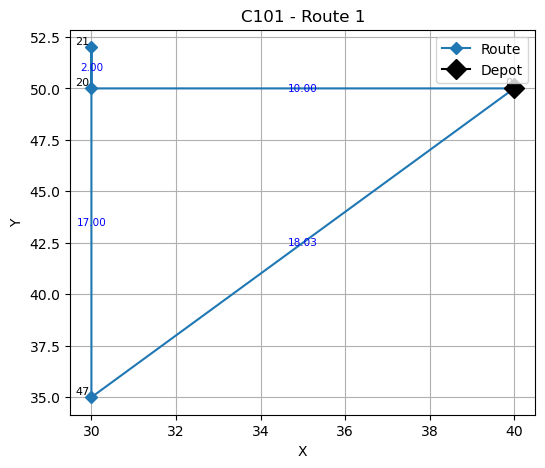

Route 2: [0, 22, 49, 0]
Truck capacity: 30.0
Total distance travelled (cost): 49
Starting time: 13h20
Ending time: 31h50
Total time: 18h30



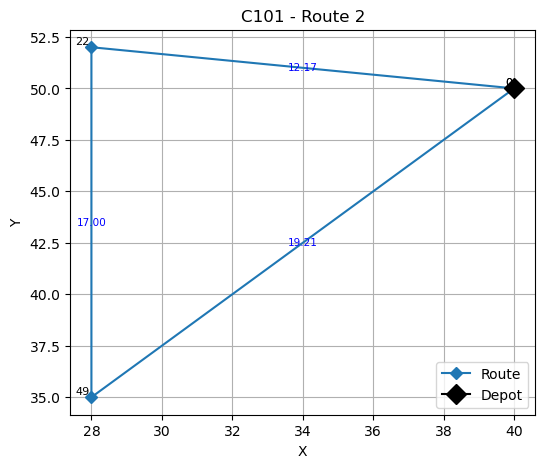

Route 3: [0, 67, 65, 63, 62, 66, 69, 75, 0]
Truck capacity: 130.0
Total distance travelled (cost): 72
Starting time: 0h00
Ending time: 19h04
Total time: 19h04



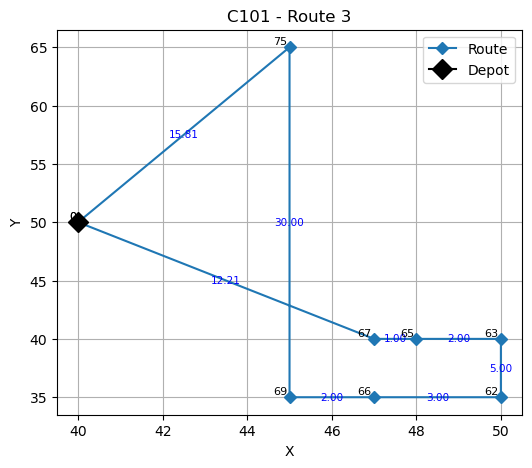

Route 4: [0, 23, 52, 0]
Truck capacity: 20.0
Total distance travelled (cost): 55
Starting time: 11h59
Ending time: 29h02
Total time: 17h03



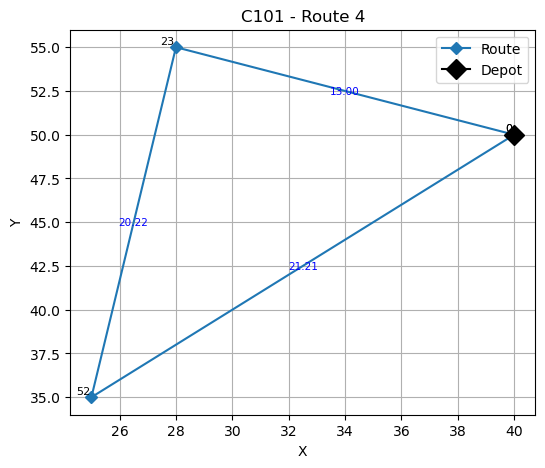

Route 5: [0, 24, 25, 27, 28, 26, 34, 50, 0]
Truck capacity: 120.0
Total distance travelled (cost): 89
Starting time: 0h50
Ending time: 17h06
Total time: 16h16



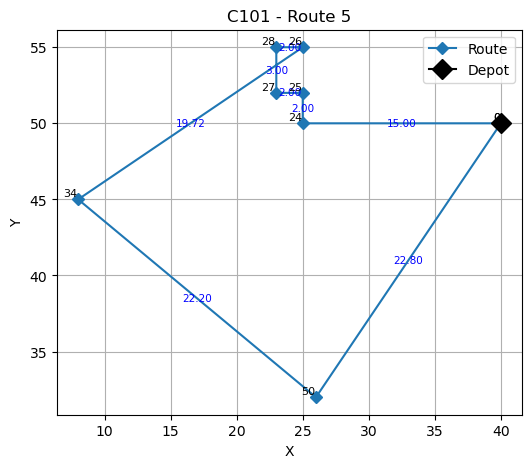

Route 6: [0, 5, 3, 4, 1, 0]
Truck capacity: 40.0
Total distance travelled (cost): 40
Starting time: 0h00
Ending time: 17h01
Total time: 17h01



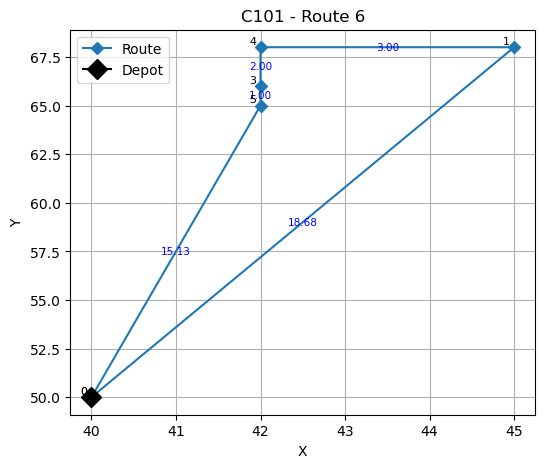

Route 7: [0, 7, 8, 9, 6, 2, 0]
Truck capacity: 100.0
Total distance travelled (cost): 49
Starting time: 2h34
Ending time: 18h10
Total time: 15h36



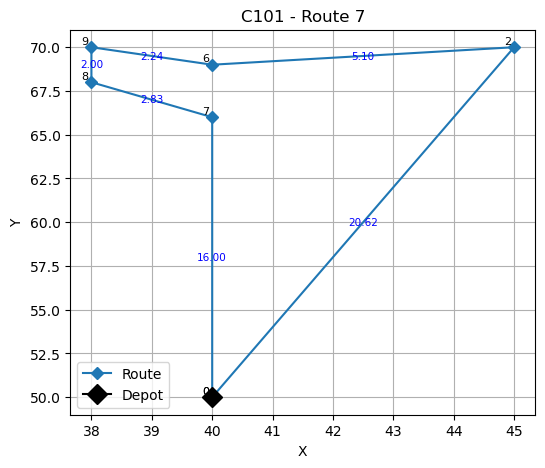

Route 8: [0, 43, 42, 41, 40, 44, 45, 48, 51, 91, 0]
Truck capacity: 100.0
Total distance travelled (cost): 103
Starting time: 0h00
Ending time: 16h14
Total time: 16h14



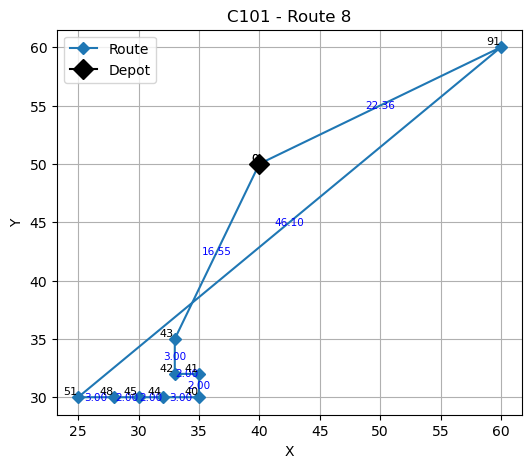

Route 9: [0, 10, 11, 12, 99, 0]
Truck capacity: 50.0
Total distance travelled (cost): 103
Starting time: 5h40
Ending time: 20h36
Total time: 14h56



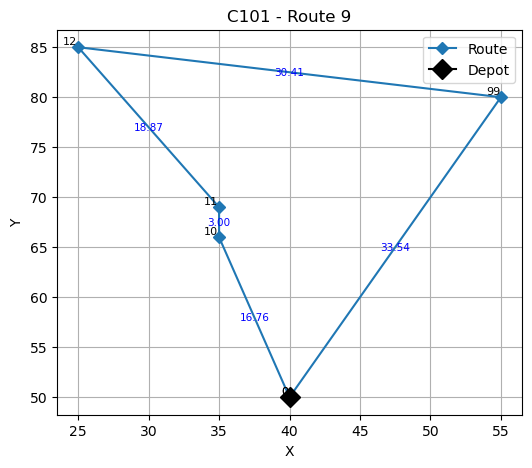

Route 10: [0, 74, 72, 61, 64, 68, 0]
Truck capacity: 90.0
Total distance travelled (cost): 54
Starting time: 5h33
Ending time: 19h38
Total time: 14h05



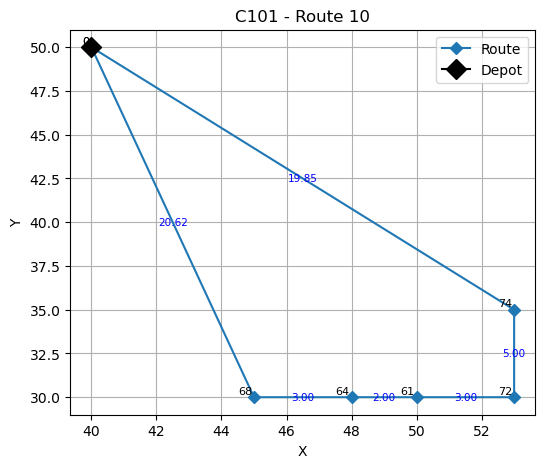

Route 11: [0, 29, 30, 36, 0]
Truck capacity: 30.0
Total distance travelled (cost): 79
Starting time: 5h38
Ending time: 18h48
Total time: 13h10



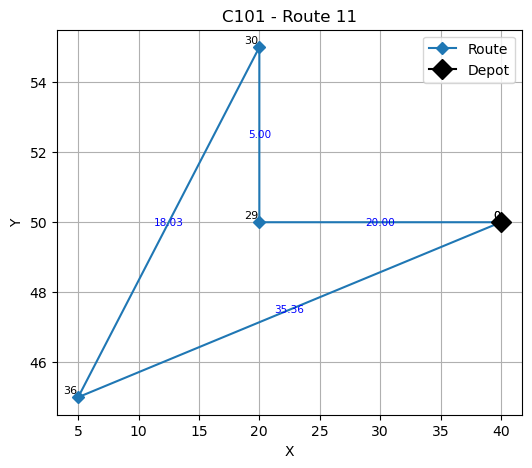

Route 12: [0, 46, 59, 80, 0]
Truck capacity: 50.0
Total distance travelled (cost): 139
Starting time: 7h07
Ending time: 22h38
Total time: 15h31



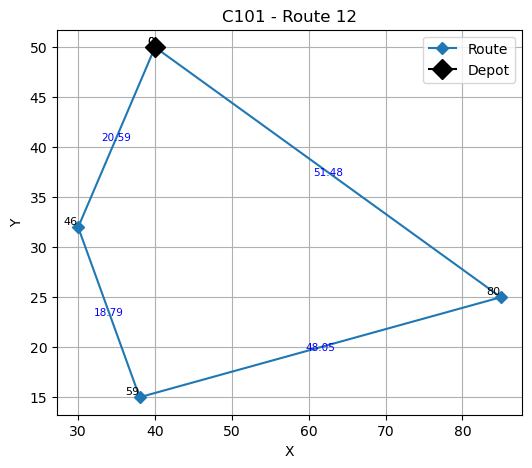

Route 13: [0, 90, 89, 0]
Truck capacity: 20.0
Total distance travelled (cost): 50
Starting time: 0h00
Ending time: 14h11
Total time: 14h11



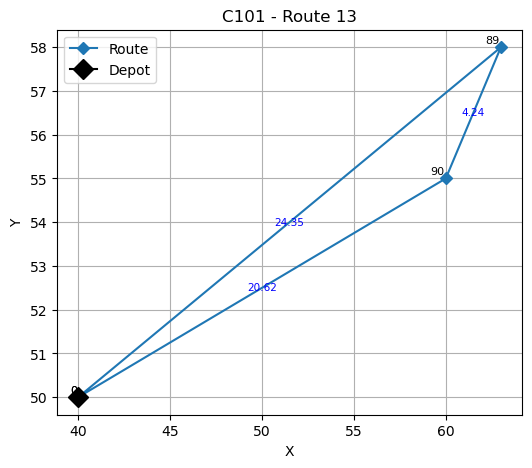

Route 14: [0, 87, 86, 84, 85, 88, 0]
Truck capacity: 110.0
Total distance travelled (cost): 65
Starting time: 1h00
Ending time: 13h44
Total time: 12h45



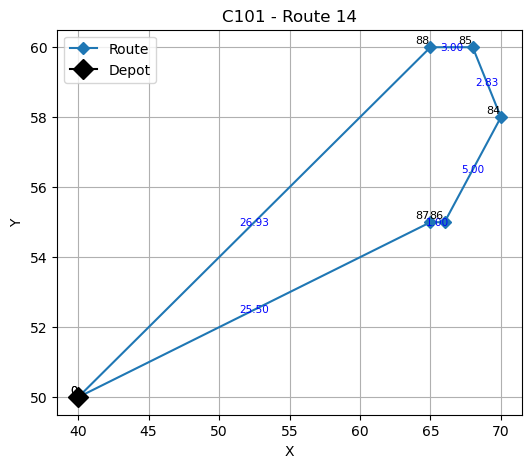

Route 15: [0, 13, 17, 18, 19, 15, 16, 14, 100, 0]
Truck capacity: 190.0
Total distance travelled (cost): 126
Starting time: 0h00
Ending time: 14h06
Total time: 14h06



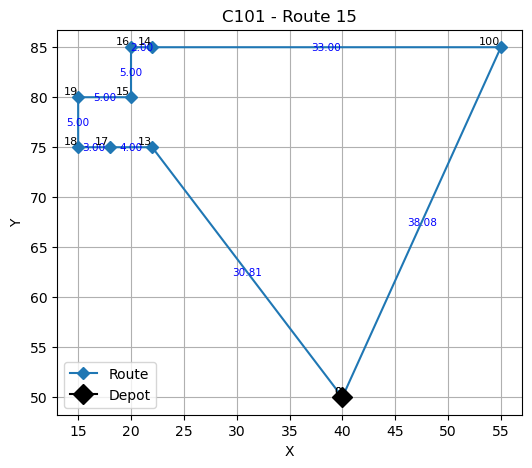

Route 16: [0, 98, 96, 95, 97, 93, 94, 79, 0]
Truck capacity: 150.0
Total distance travelled (cost): 160
Starting time: 0h00
Ending time: 14h22
Total time: 14h22



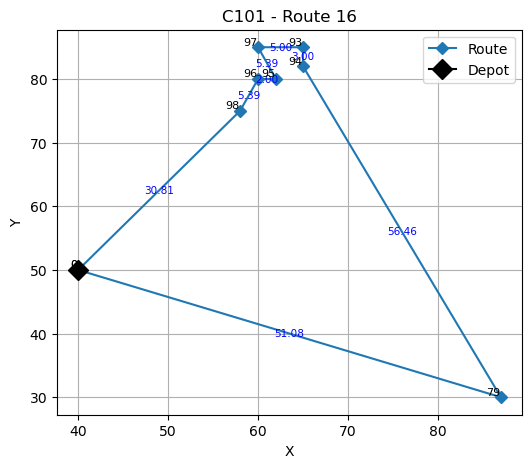

Route 17: [0, 32, 33, 31, 35, 37, 38, 39, 0]
Truck capacity: 170.0
Total distance travelled (cost): 98
Starting time: 0h00
Ending time: 12h07
Total time: 12h07



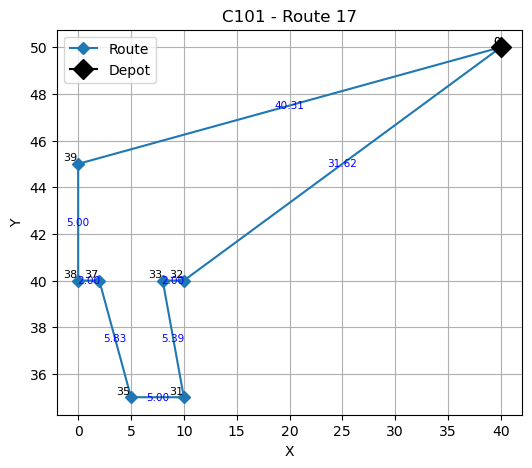

Route 18: [0, 83, 82, 77, 0]
Truck capacity: 40.0
Total distance travelled (cost): 116
Starting time: 3h53
Ending time: 15h49
Total time: 11h56



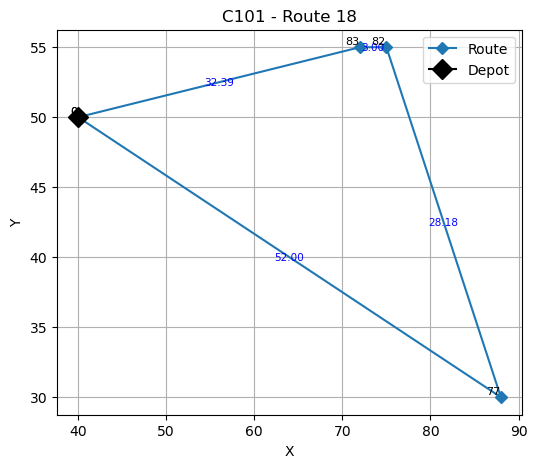

Route 19: [0, 57, 55, 54, 53, 56, 58, 60, 0]
Truck capacity: 190.0
Total distance travelled (cost): 102
Starting time: 0h00
Ending time: 12h12
Total time: 12h12



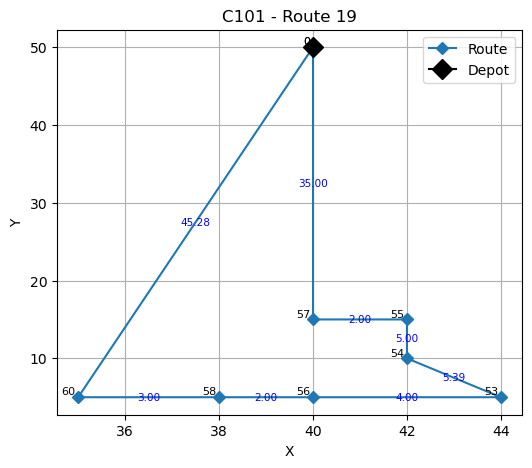

Route 20: [0, 92, 73, 0]
Truck capacity: 30.0
Total distance travelled (cost): 161
Starting time: 5h24
Ending time: 16h28
Total time: 11h04



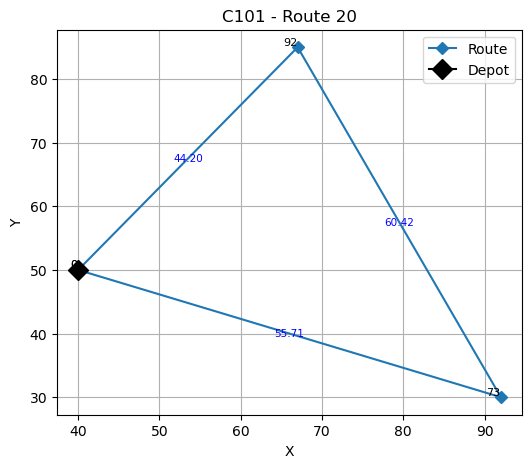

Route 21: [0, 81, 78, 76, 71, 70, 0]
Truck capacity: 110.0
Total distance travelled (cost): 121
Starting time: 0h00
Ending time: 9h31
Total time: 9h31



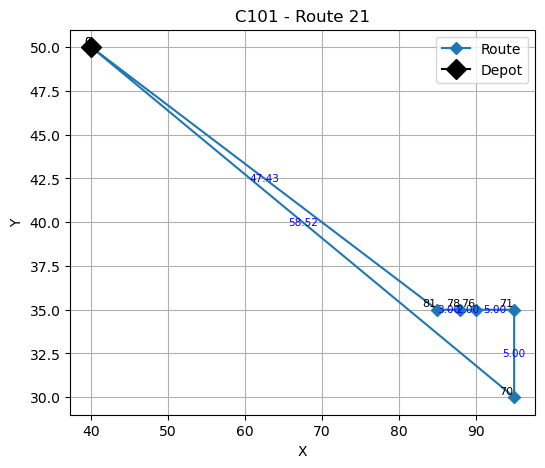

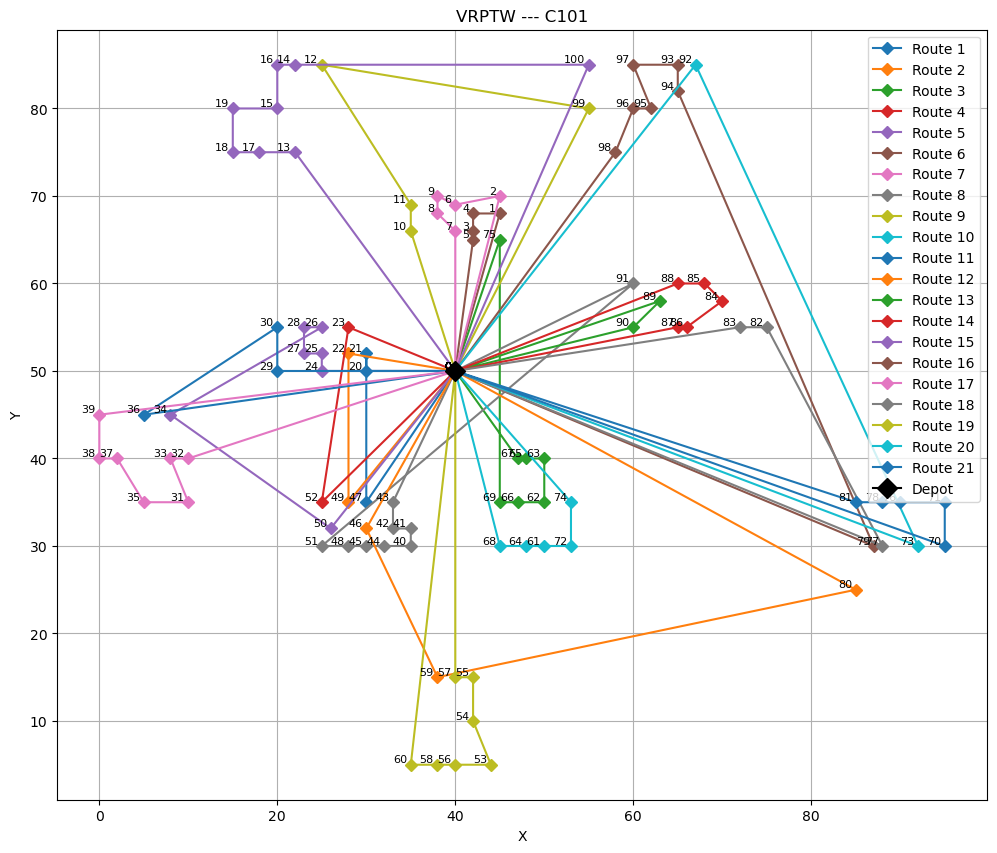

In [127]:
# Use two opt
def two_opt(routes, adj_matrix, num_iterations):
    """
    Enhanced Two-Opt heuristic for route optimization with time constraints.
    """
    best_routes = routes.copy()
    best_cost = sum(calculate_total_distance(route, adj_matrix) for route in best_routes)

    for _ in range(num_iterations):
        # Select a random route
        selected_route_index = np.random.randint(0, len(routes))
        selected_route = routes[selected_route_index]

        # Randomly pick two indices
        i, j = np.random.randint(1, len(selected_route) - 1, size=2)
        if j < i:
            i, j = j, i

        # Create a new route by reversing segment i to j
        new_route = selected_route.copy()
        new_route[i:j] = selected_route[j - 1:i - 1:-1]

        # Validate the route with time windows
        new_routes = routes.copy()
        new_routes[selected_route_index] = new_route

            # Calculate the cost for the new solution
        new_cost = sum(calculate_total_distance(route, adj_matrix) for route in new_routes)
        if new_cost < best_cost:
            best_routes = new_routes
            best_cost = new_cost

    return best_routes

def simulated_annealing(routes, adj_matrix, num_iterations, temperature):
    best_routes = routes.copy()
    current_routes = routes.copy()
    best_cost = sum(calculate_total_distance(route, adj_matrix) for route in best_routes)

    for _ in range(num_iterations):
        temp = max(0.01, temperature * (1 - (_ / num_iterations)))  # Cool down

        # Random perturbation
        selected_route_index = np.random.randint(0, len(current_routes))
        i, j = np.random.randint(1, len(current_routes[selected_route_index]) - 1, size=2)
        if j < i: i, j = j, i
        perturbed_route = current_routes[selected_route_index].copy()
        perturbed_route[i:j] = current_routes[selected_route_index][j - 1:i - 1:-1]

        # Cost calculation
        perturbed_routes = current_routes.copy()
        perturbed_routes[selected_route_index] = perturbed_route
        perturbed_cost = sum(calculate_total_distance(route, adj_matrix) for route in perturbed_routes)

        # Accept or reject
        if (perturbed_cost < best_cost or
            np.random.rand() < np.exp((best_cost - perturbed_cost) / temp)):
            current_routes = perturbed_routes
            if perturbed_cost < best_cost:
                best_routes = perturbed_routes
                best_cost = perturbed_cost

    return best_routes



def vrp_solver2(location, num_iterations):
    """
    Solve the VRP using the provided location for coordinates, vehicle capacity,
    and number of iterations for the two-opt optimization.
    """
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)
    all_routes, capacity_list, route_times, start_list = nearest_neighbor_with_time_windows(adj_matrix, demand, int(capacity_max), earliest_time, latest_time, service_time)
    optimized_routes = two_opt(all_routes, adj_matrix, num_iterations)
    #optimized_routes = simulated_annealing(all_routes, adj_matrix, num_iterations, 2000)
    route_distances = [calculate_total_distance(route, adj_matrix) for route in optimized_routes]
    formatted_routes = format_output(optimized_routes)
    return formatted_routes, route_distances, capacity_list, route_times, coordinates, start_list

# Main execution
num_iterations = 100000
solution, route_distances, capacity_list, route_times, coordinates, start_list = vrp_solver2(location, num_iterations)

# Display results
n = 0
print("Total cost: " + str(ceil(cost)))
for route, distance, route_time, start in zip(solution, route_distances, route_times, start_list):
    end = convert_time(start + route_time)
    print(f"Route {n+1}: {route}\n"
          f"Truck capacity: {capacity_list[n]}\n"
          f"Total distance travelled (cost): {ceil(distance)}\n"
          f"Starting time: {convert_time(start)}\n"
          f"Ending time: {end}\n"          
          f"Total time: {convert_time(route_time)}\n"
          )
    plot_route_with_distances(coordinates, route, f"{dataset_name.upper()} - Route {n+1}", 5)
    n += 1
    
plot_global_routes(coordinates, solution, dataset_name, 10)


### Tabu list